# Градиентный спуск

В этом домашнем задании вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек.  

In [46]:
import abc

import matplotlib.pyplot as plt
import numpy as np

## Часть 1. Градиентный спуск (5 баллов)

Для обучения линейной регрессии необходим функционал ошибки, определим интерфейс для последующих реализаций.

In [47]:
class BaseLoss(abc.ABC):
    """Base class for losses"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """Calculate loss value based on inputs and weights

        Args:
            X: array with dataset objects, (n_samples, n_features)
            y: array with ground truth values, (n_samples,)
            w: linear regression weights, (n_features,)

        Returns:
            number, loss value
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """Calculate gradient vector based on inputs and weights

        Args:
            X: array with dataset objects, (n_samples, n_features)
            y: array with ground truth values, (n_samples,)
            w: linear regression weights, (n_features,)

        Returns:
            gradients for weights, (n_features,)
        """
        raise NotImplementedError

Вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

In [48]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        result = np.sum(np.square(np.dot(X, w) - y)) / y.shape[0]
        return result

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        result = 2 * np.dot(X.T, np.dot(X, w) - y) / y.shape[0]
        return result

In [49]:
# Проведем небольшую проверку реализации

# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

In [50]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> np.ndarray:
    """Weights optimization with gradient descent

    Args:
        w_init: i# ========== TODO ==========
    #      Ваш код здесь       =
    # ==========================with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    w_history = [w_init.copy()]
    for iter in range(n_iterations):
        grad = loss.calc_grad(X=X, y=y, w=w_init)
        w_init -= lr * grad
        w_history.append(w_init.copy())
    
    w_history = np.array(w_history)
    return w_history

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [51]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [52]:
loss = MSELoss()
w_list = gradient_descent(w, X, y, loss, 0.01, 100)
print(w_list.shape)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

(101, 2)
425.58917680450253
0.8670644395649493


In [53]:
def plot_gd(w_list: np.ndarray, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """Plot gradient descent trajectory

    Args:
        w_list: weights history, (n_iterations, n_features)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`. Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

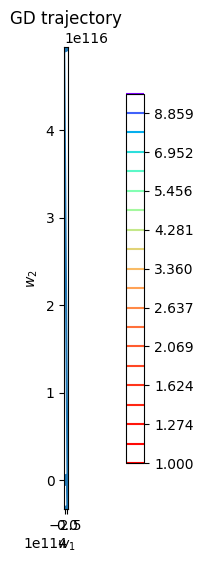

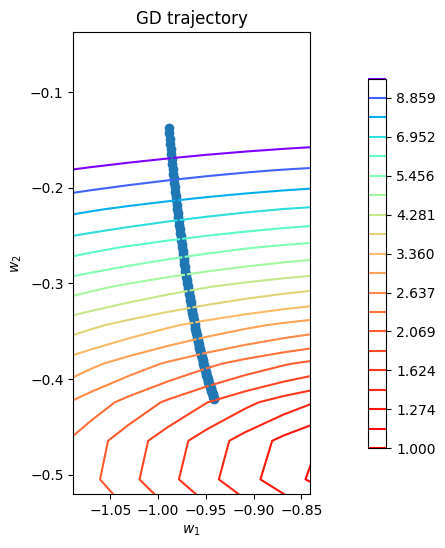

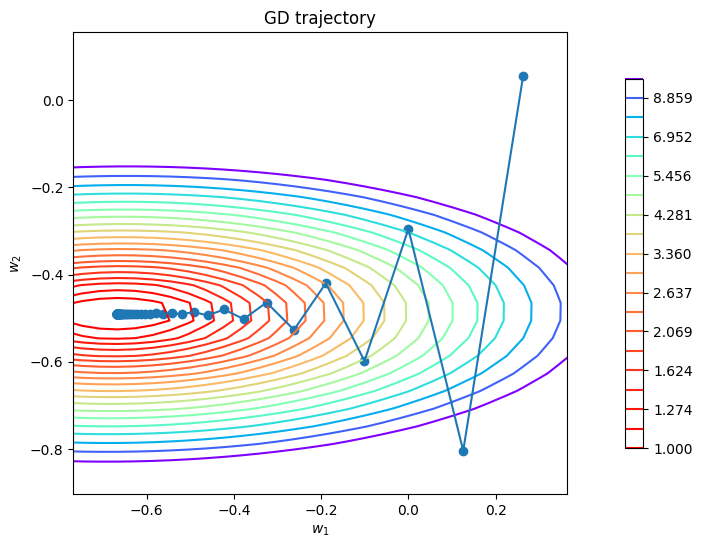

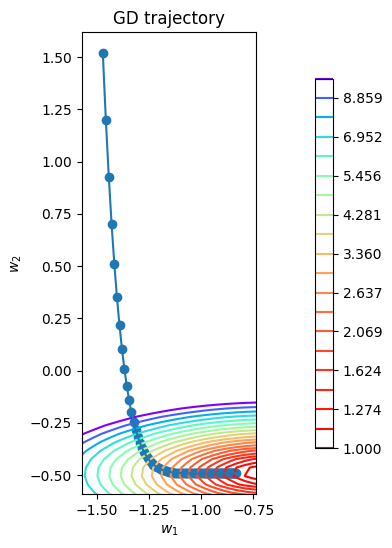

In [54]:
for lr in {0.0001, 0.001, 0.01, 0.1}:
    w = np.random.uniform(-2, 2, (n_features))
    w_list = gradient_descent(w_init=w, X=X, y=y, loss=loss, lr=lr, n_iterations=100)
    plot_gd(w_list=w_list, X=X, y=y, loss=loss)

Теперь реализуем стохастический градиентный спуск. Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча.

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [55]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> np.ndarray:
    """Weights optimization with stochastic gradient descent

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        batch_size: number of samples in each batch, int
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    
    w_history = [w_init.copy()]
    for iter in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        batch = X[batch_indices]
        y_batch = y[batch_indices]
        grad = loss.calc_grad(X=batch, y=y_batch, w=w_init)
        w_init -= lr * grad
        w_history.append(w_init.copy())
    
    w_history = np.array(w_history)
    return w_history

In [56]:
batch_indices = np.random.choice(X.shape[0], size=5, replace=False)
batch = X[batch_indices]
print(X.shape)
print(y[batch_indices])
print(y.shape)

(300, 2)
[ 2.99347098  5.98464135 -1.13930559  5.08096866 -0.72803153]
(300,)


При помощи функций `stochastic_gradient_descent` и `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`.

Сделайте и опишите свои выводы о том, как параметры `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

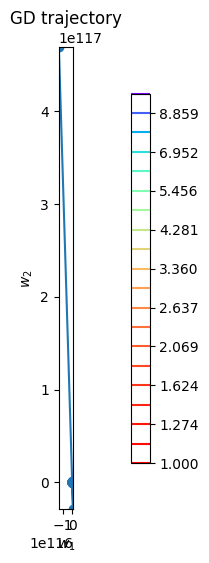

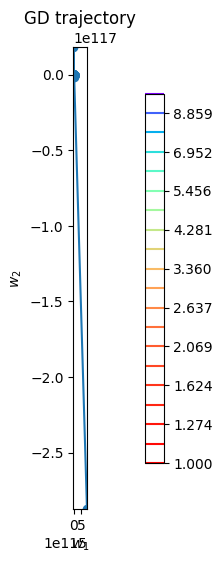

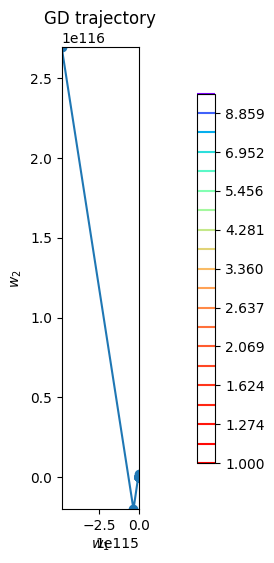

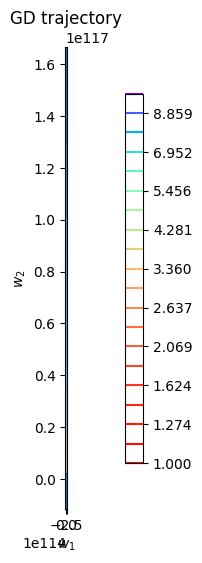

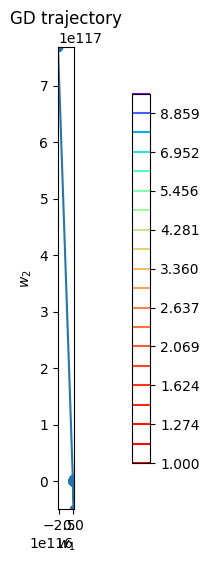

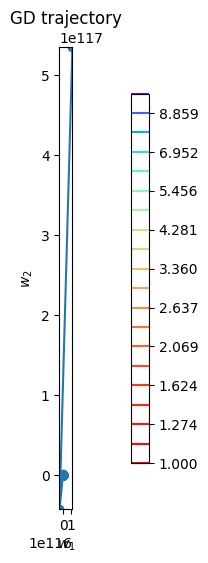

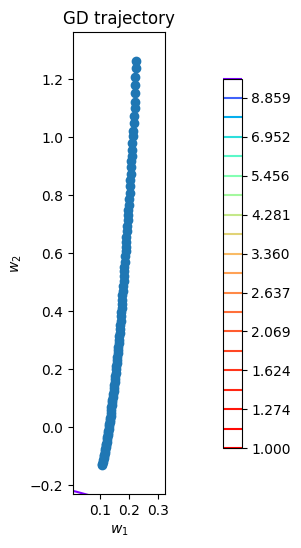

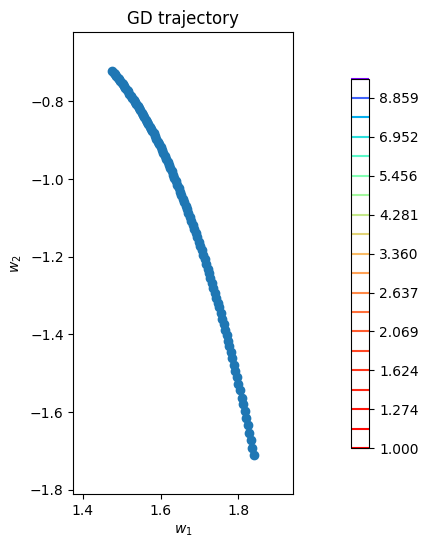

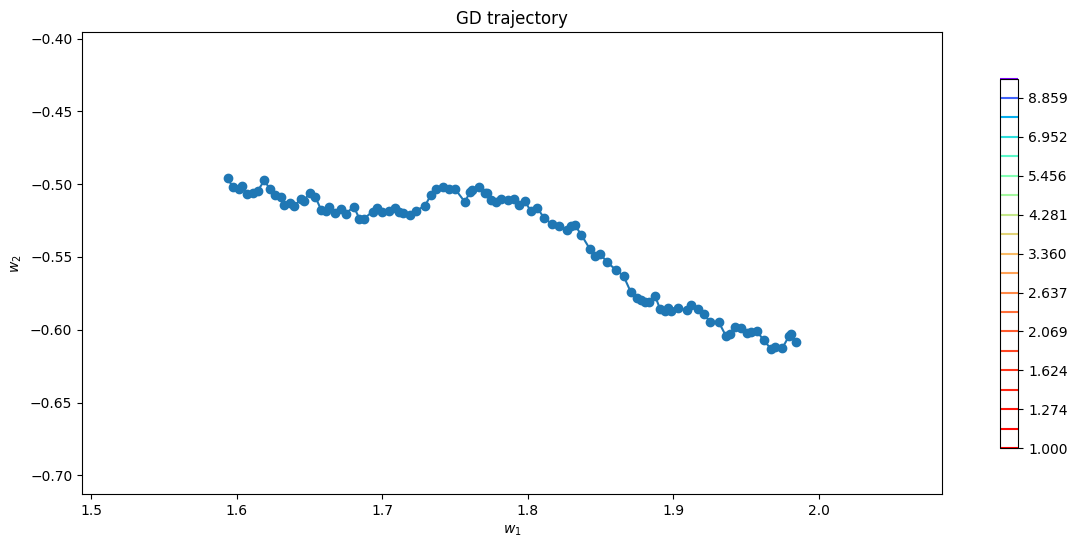

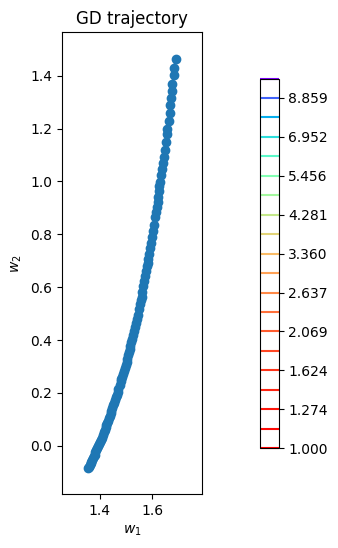

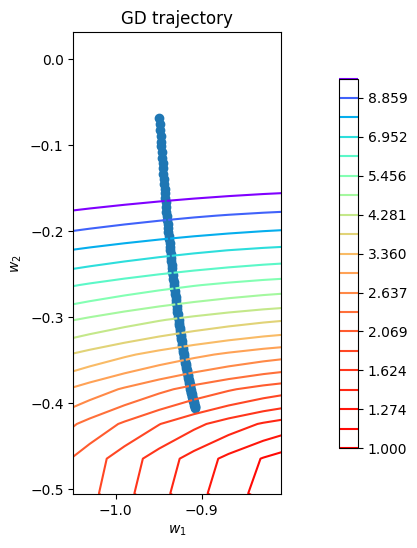

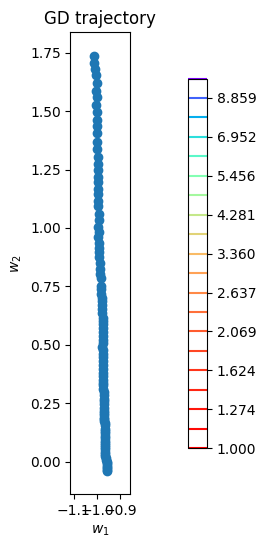

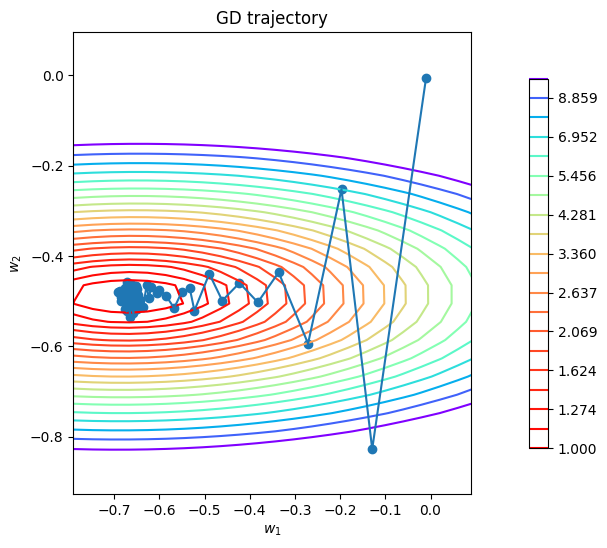

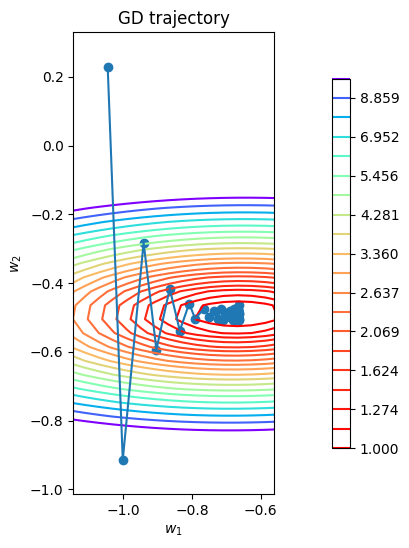

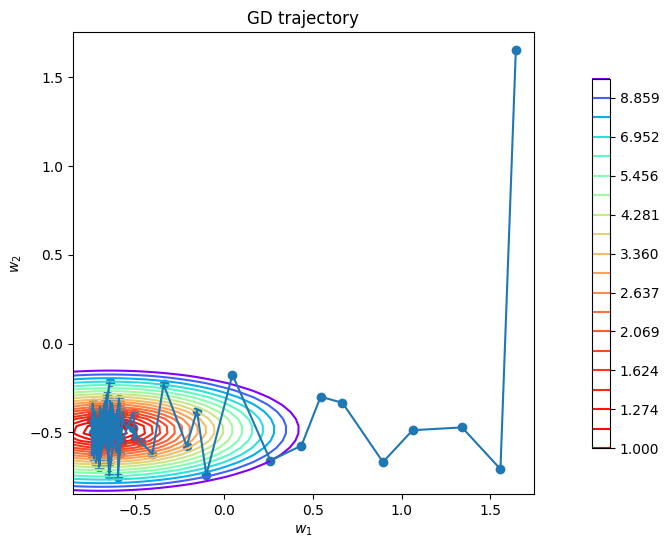

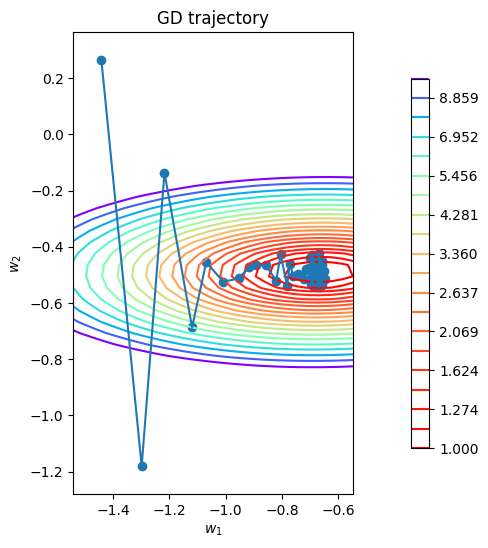

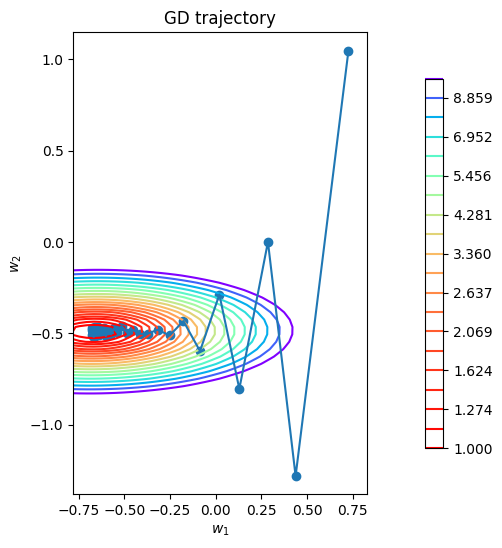

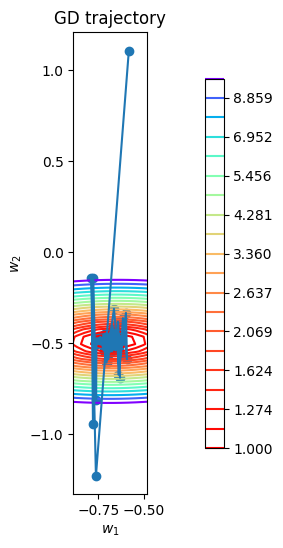

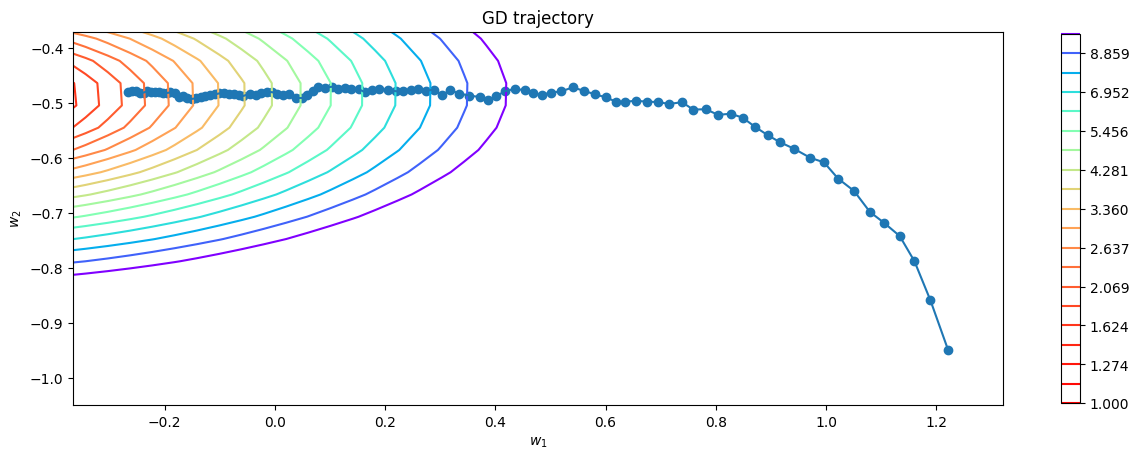

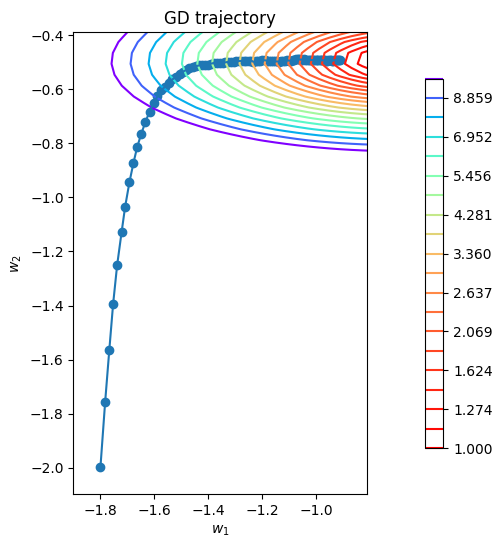

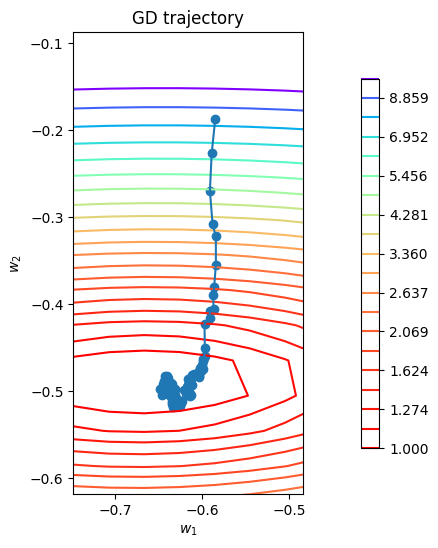

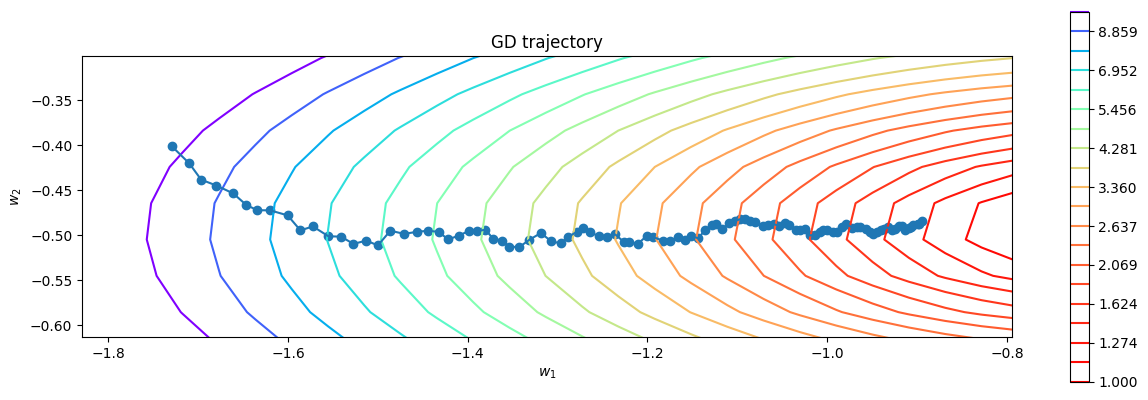

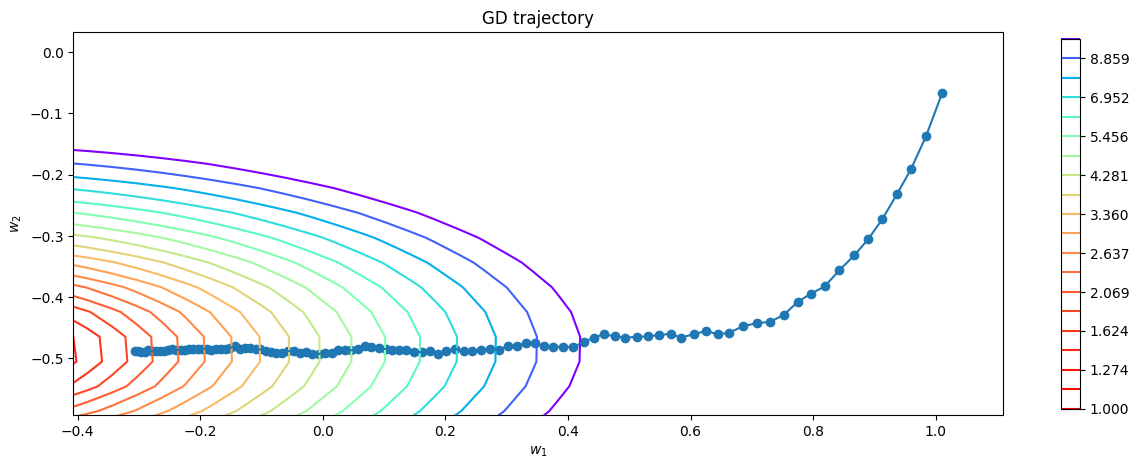

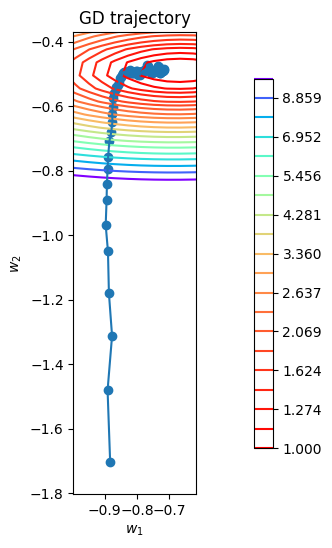

In [57]:
for lr in {0.0001, 0.001, 0.01, 0.1}:
    for batch_size in {10, 25, 50, 100, 150, 200}:
        w = np.random.uniform(-2, 2, (n_features))
        w_list = stochastic_gradient_descent(w_init=w, X=X, y=y, loss=loss, lr=lr, batch_size=batch_size, n_iterations=100)
        plot_gd(w_list=w_list, X=X, y=y, loss=loss)

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага.

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его.

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

Реализуйте SGD на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [58]:
def stochastic_gradient_descent_with_decay(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> np.ndarray:
    """Weights optimization with SGD and learning rate decay

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        batch_size: number of samples in each batch, int
        p: learning rate decay factor, float
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    w_history = [w_init.copy()]
    for iter in range(n_iterations):
        current_lr = lr * (1 / (1 + iter)) ** p
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        batch = X[batch_indices]
        y_batch = y[batch_indices]
        grad = loss.calc_grad(X=batch, y=y_batch, w=w_init)
        w_init -= current_lr * grad
        w_history.append(w_init.copy())
    
    w_history = np.array(w_history)
    return w_history

При помощи новой функции `stochastic_gradient_descent_with_decay` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

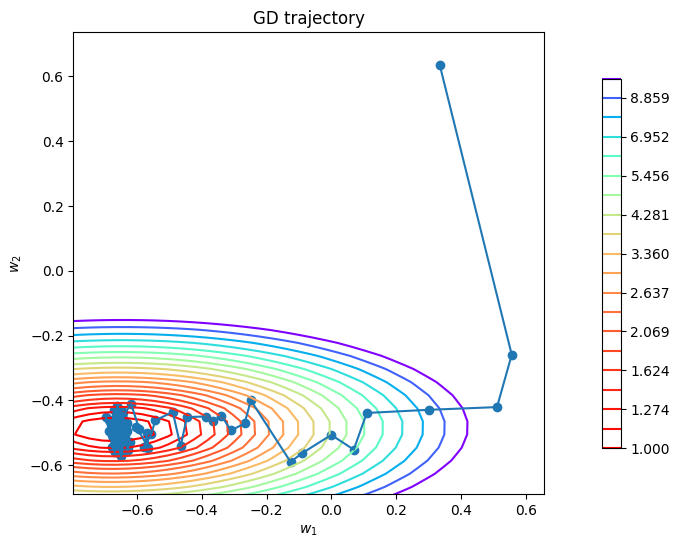

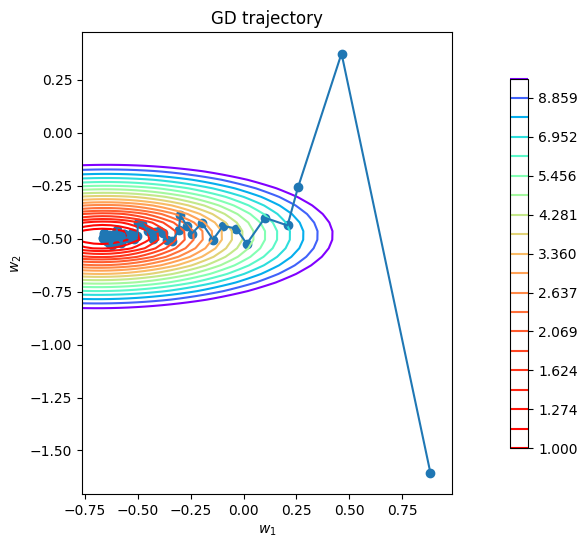

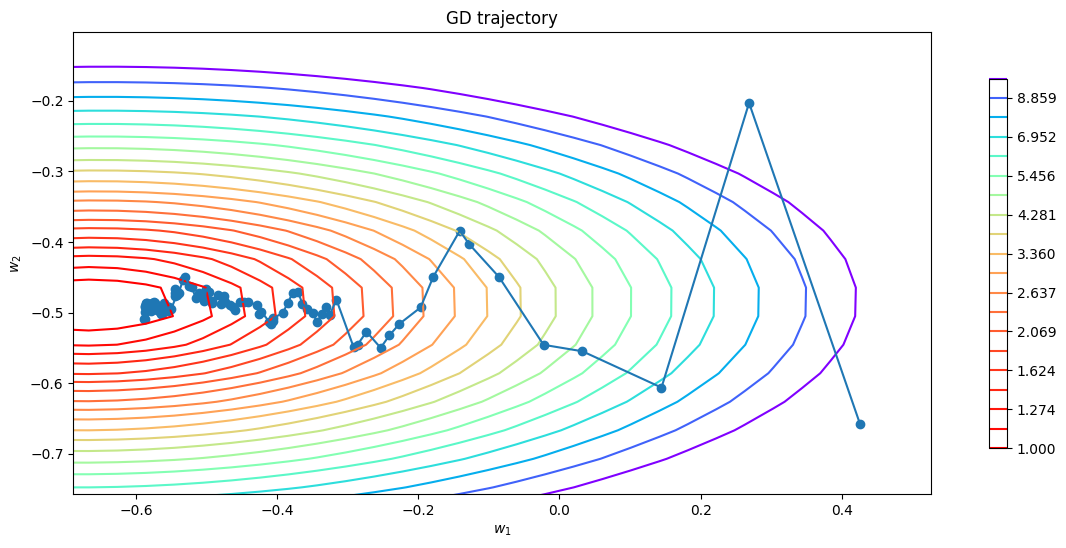

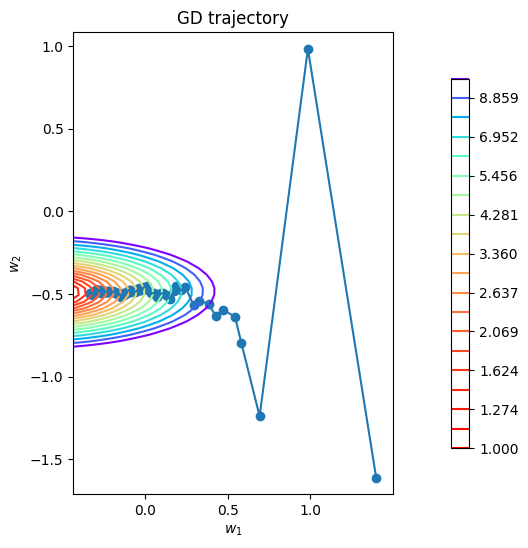

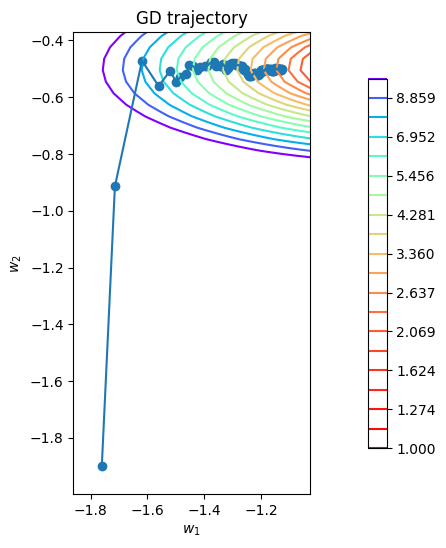

In [59]:
for p in np.arange(0.1, 1.1, 0.2):
    w = np.random.uniform(-2, 2, (n_features))
    w_list = stochastic_gradient_descent_with_decay(w_init=w, 
                                                    X=X, 
                                                    y=y, 
                                                    loss=loss, 
                                                    lr=0.01, 
                                                    batch_size=10, 
                                                    p=p, 
                                                    n_iterations=100)
    plot_gd(w_list=w_list, X=X, y=y, loss=loss)

Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

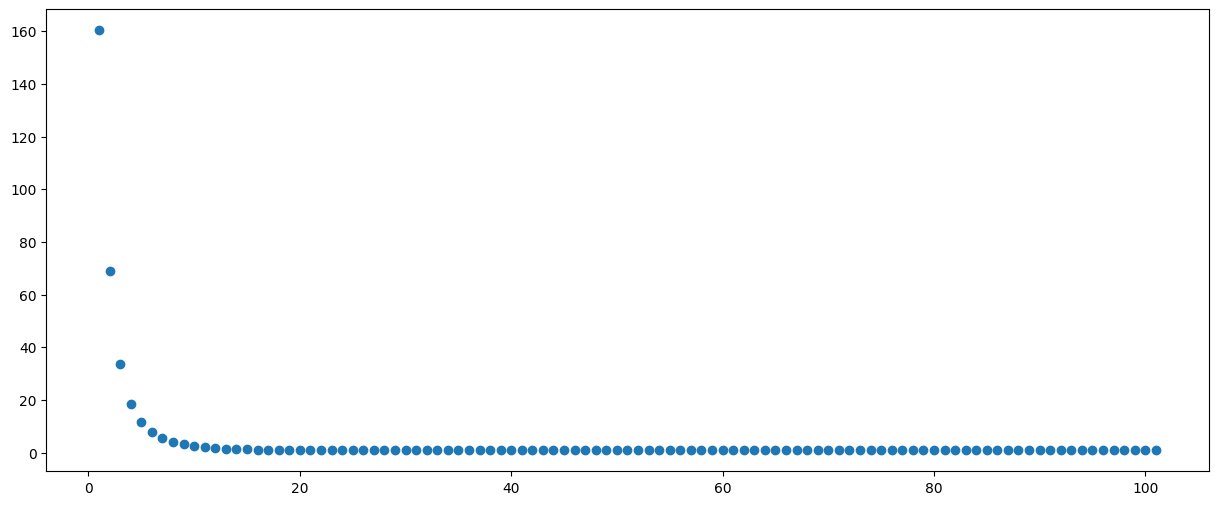

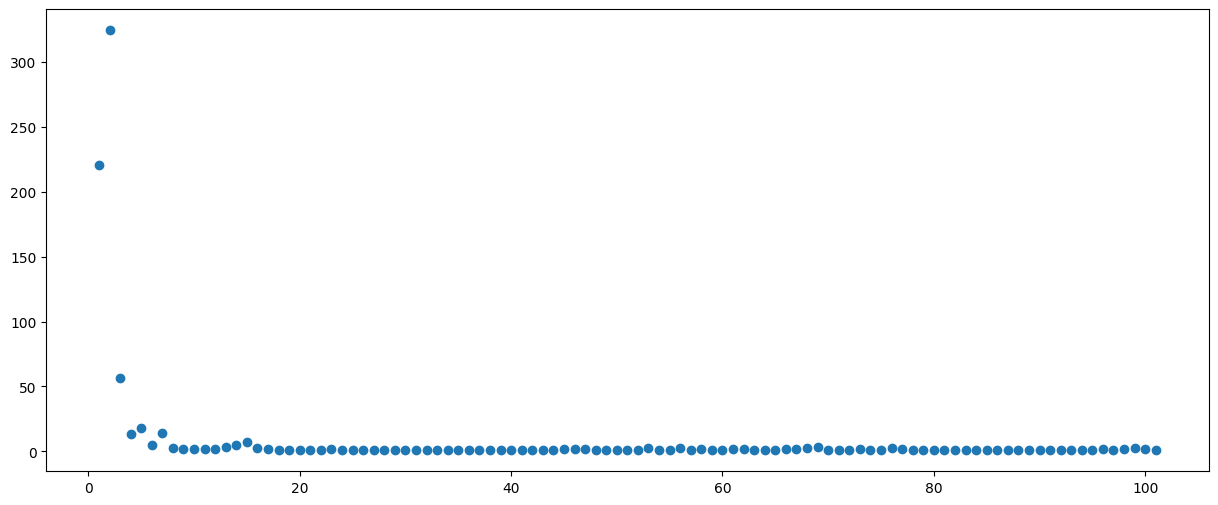

In [60]:
w = np.random.uniform(-2, 2, (n_features))
w_list_gd = gradient_descent(w_init=w,
                             X=X,
                             y=y,
                             loss=loss,
                             lr=0.01,
                             n_iterations=100)
w = np.random.uniform(-2, 2, (n_features))
w_list_sgd = stochastic_gradient_descent(w_init=w,
                                                    X=X,
                                                    y=y,
                                                    loss=loss,
                                                    lr=0.01,
                                                    batch_size=10,
                                                    n_iterations=100)

loss_values_gd = [loss.calc_loss(X, y, w) for w in w_list_gd]
loss_values_sgd = [loss.calc_loss(X, y, w) for w in w_list_sgd]

plt.figure(figsize=(15, 6))
plt.scatter(np.arange(1, w_list_gd.shape[0] + 1), loss_values_gd)

plt.figure(figsize=(15, 6))
plt.scatter(np.arange(1, w_list_sgd.shape[0] + 1), loss_values_sgd)

## Часть 2. Линейная регрессия (5 баллов)

Напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`. Не забывайте про единичный признак!

В методе `predict` мы будем применять нашу регрессию к датасету,

In [61]:
w = np.random.uniform(-2, 2, X.shape[1])
w_list = gradient_descent(w_init=w, X=X, y=y, loss=loss, lr=lr)
print(loss.calc_loss(X=X, y=y,w=w))
print(loss.calc_loss(X=X, y=y,w=w_list[-1]))

0.8670644395649091
0.8670644395649091


In [62]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        self.w = np.random.uniform(-2, 2, X.shape[1])
        gradient_descent(w_init=self.w, 
                         X=X, 
                         y=y, 
                         loss=self.loss, 
                         lr=self.lr)

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        return np.dot(X, self.w)

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации.

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [63]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [64]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw = X_raw[~X_raw[25].isna()].reset_index()
X_raw.head()

,index,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,24,25
0,0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,3,2,164.0,audi,gas,std,four,sedan,fwd,front,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,4,2,164.0,audi,gas,std,four,sedan,4wd,front,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [65]:
features = []
for feature in X_raw.columns:
    features.append(str(feature) + '_')

X_raw.columns = features
X_raw.head()

,index_,0_,1_,2_,3_,4_,5_,6_,7_,8_,...,16_,17_,18_,19_,20_,21_,22_,23_,24_,25_
0,0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,3,2,164.0,audi,gas,std,four,sedan,fwd,front,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,4,2,164.0,audi,gas,std,four,sedan,4wd,front,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [66]:
y = X_raw['25_']
X_raw = X_raw.drop(['25_'], axis=1)



Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

numeric_data = X_train.select_dtypes([np.number])
numeric_features = numeric_data.columns
X_train = X_train.fillna(numeric_data.median())
X_test = X_test.fillna(numeric_data.median())

categorial = list(X_train.dtypes[X_train.dtypes == 'object'].index)
X_train[categorial] = X_train[categorial].fillna('NotGiven')
X_test[categorial] = X_test[categorial].fillna('NotGiven')

column_transformer = ColumnTransformer(
    [('ohe', OneHotEncoder(handle_unknown="ignore"), categorial), ('scaling', StandardScaler(), numeric_features)]
)

# cat_data = X_test[categorial]
# ohe_transform = OneHotEncoder(handle_unknown="ignore")
# print(ohe_transform.fit(cat_data).get_feature_names_out())
# proba = ohe_transform.transform(X_train[categorial])
# ohe_transform.transform(X_test[categorial])

# X_test.shape

column_transformer.fit(X_train)
X_transform_train = column_transformer.transform(X_train)
X_transform_test = column_transformer.transform(X_test)

Обучите линейную регрессию на обучающей выборке

In [69]:
mse_loss = MSELoss()
model = LinearRegression(mse_loss)
model.fit(X_transform_train, y_train)
result = model.predict(X_transform_test)

Для оценки качества реализуем `r2_score`, который является нормализацией `mean_square_error`.

In [70]:
def r2(y_true: np.ndarray, y_predicted: np.ndarray) -> float:
    y_mean = np.mean(y_true)
    mse = np.sum(np.square(y_true - y_predicted))
    mse_const = np.sum(np.square(y_true - y_mean * np.ones(y_true.shape[0])))
    return 1 - mse / mse_const

Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке.

In [71]:
print(r2(model.predict(X_transform_train), y_train))
print(r2(y_test, result))

0.9727251824042165
0.9037297144211874


In [72]:
from sklearn.metrics import r2_score
print(r2_score(model.predict(X_transform_train), y_train))
print(r2_score(y_test, result))

0.9727251824042165
0.9037297144211874


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

Обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак).

**Вопрос**: надо ли регуляризовывать bias?

**Ответ**: $\textit{TODO}$

Не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [73]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        return np.sum(np.square(np.dot(X, w) - y)) / y.shape[0] + self.coef * np.sum(np.square(w))

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        return 2 * np.dot(X.T, np.dot(X, w) - y) / y.shape[0] + 2 * self.coef * w

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [74]:
linear_regression = LinearRegression(MSEL2Loss(0.1))

Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации.

In [75]:
from tqdm import tqdm

best_coef = 0
best_r2_score = 0
for coef in tqdm(np.arange(0.0015, 0.0025, 0.0002)):
# for coef in np.arange(0.001, 1, 0.002):
    model = LinearRegression(MSEL2Loss(coef))
    model.fit(X_transform_train, y_train)
    result = model.predict(X_transform_test)
    cur_r2 = r2(y_test, result)
    if cur_r2 > best_r2_score:
        best_r2_score = cur_r2
        best_coef = coef

print(best_coef)


100%|██████████| 5/5 [00:17<00:00,  3.57s/it]

0.0021000000000000003


In [76]:
easy_model = LinearRegression(MSELoss())
easy_model.fit(X_transform_train, y_train)
easy_result = easy_model.predict(X_transform_test)
l2_model = LinearRegression(MSEL2Loss(best_coef))
l2_model.fit(X_transform_train, y_train)
l2_result = l2_model.predict(X_transform_test)
print('Easy model, r2: ', r2(y_test, easy_result))
print('l2 model, r2: ', r2(y_test, l2_result))

Easy model, r2:  0.9037313682928121
l2 model, r2:  0.929776558045956


В нашем датасете могут быть выбросы, с ними хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

In [98]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        error = np.dot(X, w) - y
        mask_small_error = np.abs(error) < self.eps
        small_error = error[mask_small_error]
        big_error = error[~mask_small_error]
        loss_value_small_error = np.sum(np.square(small_error)) / 2
        loss_value_big_error = np.sum(self.eps * (np.abs(big_error) - self.eps / 2))
        return (loss_value_small_error + loss_value_big_error) / error.shape[0]
        

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        error = np.dot(X, w) - y
        mask_small_error = np.abs(error) < self.eps
        # grad_fi[mask_small_error] = X[mask_small_error] * error[mask_small_error]
        # grad_fi[~mask_small_error] = X[~mask_small_error] * self.eps * np.sign(error[~mask_small_error])
        # return np.sum(mask_small_error) / error.shape[0]
        grad_fi_small_error = np.dot(X[mask_small_error].T, error[mask_small_error])
        grad_fi_big_error = np.dot(X[~mask_small_error].T, self.eps * np.sign(error[~mask_small_error]))
        return (grad_fi_small_error + grad_fi_big_error) / error.shape[0]

Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [99]:
huber_loss = HuberLoss(400)
print(huber_loss.calc_loss(X_transform_train, y_train, easy_model.w))
print(huber_loss.calc_grad(X_transform_train, y_train, easy_model.w))

265218.73449464515
[-2.50000000e+00  3.07000397e+00  1.93606859e+00 -2.25643496e-01
 -4.73378362e-01  4.94435770e+00 -1.51479672e-01 -2.66990716e-01
  7.49892362e+00 -8.19907872e-02 -4.25296634e-02  2.09645867e+00
 -2.82722180e+00 -4.92316154e+00  7.55517655e-01  1.67667501e-01
  1.82236234e-01  0.00000000e+00 -3.49289872e+00 -8.68156819e+00
  4.83357827e-01  9.49159010e-01 -4.93785364e+00  3.35474146e+00
 -4.60241906e+00  3.01930688e+00 -1.49449406e-02 -3.78624936e+00
  2.21808213e+00  0.00000000e+00  2.43068775e+00 -4.59370784e-01
  1.58791713e+00 -5.14234627e+00 -2.09735562e-02  1.09927506e+00
 -2.66141368e+00 -1.51379992e+00 -6.93122526e-02 -5.28517480e+00
 -4.92789972e+00  7.86271793e+00 -3.56221097e+00  2.53572057e+00
  1.79373481e+00  0.00000000e+00  3.38993438e+00 -1.12725552e+01
  4.49232793e+00 -4.73817640e-03  1.81840884e-02  1.79373481e+00
  4.94435770e+00 -8.20210687e+00  1.79373481e+00 -4.93785364e+00
 -6.85725779e-03  2.31176921e+00  2.50136410e+00  1.24797774e-02
 -2.28

In [43]:
print((y_test - easy_result).median())
print((y_test - easy_result).mean())
print((y_test - easy_result).mode())
print((y_test - easy_result).max())
print((y_test - easy_result).std())


206.9261642720885
450.28164494342667
0     -9413.790501
1     -8266.694599
2     -2521.057553
3     -2343.511104
4     -2149.347443
5     -1181.001132
6     -1099.275329
7     -1068.523355
8     -1052.061058
9     -1010.850084
10     -952.907432
11     -501.109546
12     -496.456412
13     -465.961796
14     -300.019063
15      -67.769017
16      -56.816355
17      -40.116978
18      -23.298511
19       74.960809
20      206.926164
21      241.391059
22      287.733425
23      326.548204
24      392.272843
25      593.864477
26      663.241254
27     1182.952657
28     1381.119403
29     1728.965758
30     1857.102295
31     1994.070077
32     2303.721180
33     2322.605801
34     2574.290458
35     2957.792478
36     3002.085681
37     3560.958653
38     3863.635840
39     6435.142297
40    13520.733900
Name: 25_, dtype: float64
13520.733899609986
3444.530149476773


In [106]:
from tqdm import tqdm

best_coef = 0
best_r2_score = 0
for coef in tqdm(range(0, 160, 10)):
    model = LinearRegression(HuberLoss(coef))
    model.fit(X_transform_train, y_train)
    result = model.predict(X_transform_test)
    cur_r2 = r2(y_test, result)
    if cur_r2 > best_r2_score:
        best_r2_score = cur_r2
        best_coef = coef

print(best_coef)


100%|██████████| 16/16 [02:08<00:00,  8.05s/it]

90


In [107]:
huber_model = LinearRegression(HuberLoss(best_coef))
huber_model.fit(X_transform_train, y_train)
huber_resalt = huber_model.predict(X_transform_test)
print('Easy model, r2: ', r2(y_test, easy_result))
print('l2 model, r2: ', r2(y_test, l2_result))
print('Huber model, r2: ', r2(y_test, huber_resalt))

Easy model, r2:  0.9037313682928121
l2 model, r2:  0.929776558045956
Huber model, r2:  0.9266574785896273


Вставьте ваш любимый мем 2025 в ячейку ниже:

In [ ]:
# ========== TODO ==========
#      Ваш мем здесь       =
# ==========================